# Modello di mediazione con Stan

## Preparazione del Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel
import networkx as nx

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_mediation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

Il presente capitolo fornisce un riassunto della trattazione dei modelli misti fornita da {cite:t}`sorensen2015bayesian`, a cui si rimanda per gli approfondimenti.

## Domanda della Ricerca

La questione scientifica riguarda la comprensione delle frasi nel caso di proposizioni relative di soggetto e di oggetto. Una proposizione relativa di soggetto è una frase in cui un sostantivo (ad esempio, "senatore") viene modificato da una proposizione relativa (ad esempio, "che ha interrogato il giornalista"), e il sostantivo modificato è il soggetto grammaticale della proposizione relativa. In una proposizione relativa di oggetto, il sostantivo modificato dalla proposizione relativa è l'oggetto grammaticale della proposizione (per esempio, "Il senatore che il giornalista ha interrogato si è dimesso"). In entrambi i casi, il sostantivo modificato ("senatore") è chiamato il sostantivo principale.

Un risultato comune per l'inglese è che le proposizioni relative di soggetto sono più facili da elaborare rispetto a quelle di oggetto. Le lingue naturali in generale includono proposizioni relative, e fino a poco tempo fa il vantaggio delle proposizioni di soggetto è stato considerato valido a livello cross-linguistico. Tuttavia, le proposizioni relative in cinese rappresentano un interessante controesempio a questa generalizzazione; ricerche recenti condotte da Hsiao e Gibson (2003) hanno suggerito che in cinese, le proposizioni relative di oggetto sono più facili da elaborare rispetto a quelle di soggetto in un punto specifico della frase (il sostantivo principale della proposizione relativa). Viene presentata un'analisi di un insieme di dati successivamente pubblicata {cite:p}`gibson2013processing` che valuta questa affermazione.

## I Dati

La variabile dipendente dell'esperimento di {cite:t}`gibson2013processing` era il tempo di lettura (rt) in millisecondi del sostantivo principale della proposizione relativa. Questo è stato registrato in due condizioni (proposizione relativa di soggetto e proposizione relativa di oggetto), con 37 soggetti e 15 item, presentati in un disegno standard a quadrato latino. Originariamente c'erano 16 item, ma uno è stato rimosso, risultando in 37 × 15 = 555 punti dati. Tuttavia, otto punti dati da un soggetto (id 27) erano mancanti. Di conseguenza, abbiamo un totale di 555 - 8 = 547 punti dati. La condizione (object relative / subject relative) è codificata dalla variabile `so`.

In [3]:
howell_data = pd.read_csv("../data/Howell1.csv", sep=';')
howell_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
howell_data.tail()

,height,weight,age,male
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1
543,158.750,52.531624,68.0,1


In [5]:
howell_data.shape

(544, 4)

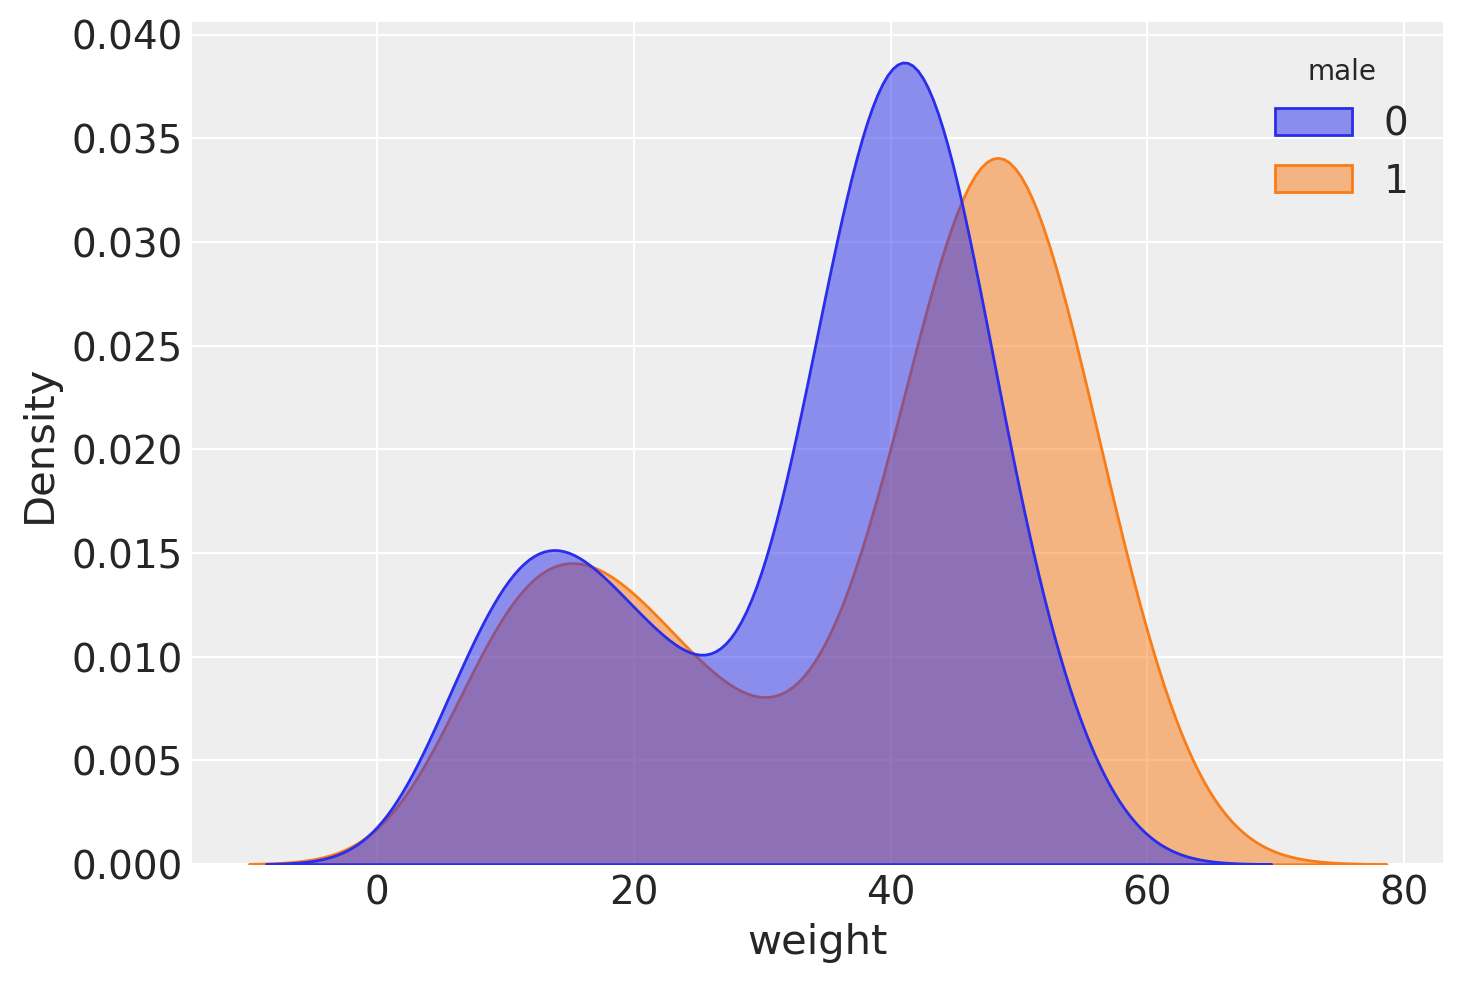

In [6]:
_ = sns.kdeplot(data=howell_data, x='weight', hue='male', fill=True, common_norm=False, alpha=0.5)

## Pensare scientificamente prima di tutto

Desideriamo prevedere il peso a partire da due predittori: genere e altezza. Pertanto, potremmo prevedere il peso utilizzando queste due variabili mediante un modello di regressione. {cite:t}`McElreath_rethinking` ci ricorda che il modello di regressione è un "Golem": è potente e stupido.  Se il nostro unico obiettivo è "prevedere" il valore del peso senza attribuire interpretazioni ai coefficienti del modello, questo potrebbe essere adeguato se funziona effettivamente. Tuttavia, il modello di regressione non considera la struttura causale sottostante il meccanismo di generazione dei dati. Se desideriamo comprendere qualcosa sulla struttura causale che lega questi dati, dobbiamo prima pensare in termini scientifici.

- Come sono **causalmente** correlati altezza, peso e sesso?
- Come sono **statisticamente** correlati altezza, peso e sesso?

### Le cause non sono nei dati

L'altezza dovrebbe influenzare il peso, e non il contrario:
- ✅ $H \rightarrow W$
- ❌ $W \rightarrow H$

Il sesso dovrebbe influenzare l'altezza, e non il contrario:
- ❌ $S \rightarrow H$
- ✅ $H \rightarrow S$

Questo ci porta a un modello di mediazione. In tale modello, il sesso influisce sul peso ($S \rightarrow W$) così come sull'altezza ($S \rightarrow H$). Inoltre, l'altezza influisce sul peso ($H \rightarrow W$). In questa struttura causale, possiamo distinguere tra effetti diretti, indiretti e l'effetto totale.

L'effetto diretto del genere sul peso è dato dal coefficiente del percorso $S \rightarrow W$. Questa è la nostra principale questione di interesse. Tuttavia, c'è un altro effetto diretto che influisce sul peso: $H \rightarrow W$. Se confrontiamo questi due effetti diretti, quale è il più significativo? In aggiunta, abbiamo l'effetto diretto $S \rightarrow H$. Possiamo anche definire l'effetto indiretto del sesso sul peso come $S \rightarrow H \rightarrow W$. Infine, l'effetto totale è dato dalla somma degli effetti diretti e indiretti.

Tutto ciò viene ignorato in un modello di regressione semplice. Solo quando disponiamo di un modello plausibile che descrive le relazioni causali tra le variabili possiamo costruire un modello statistico in grado di rappresentare adeguatamente la struttura causale ipotizzata, permettendoci di rispondere alle domande di interesse. In questo caso, quale è l'effetto più rilevante sul peso? Altezza o genere? Per rispondere a questa domanda, possiamo implementare il modello di mediazione in Stan nel seguente modo.

/opt/anaconda3/envs/stan_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


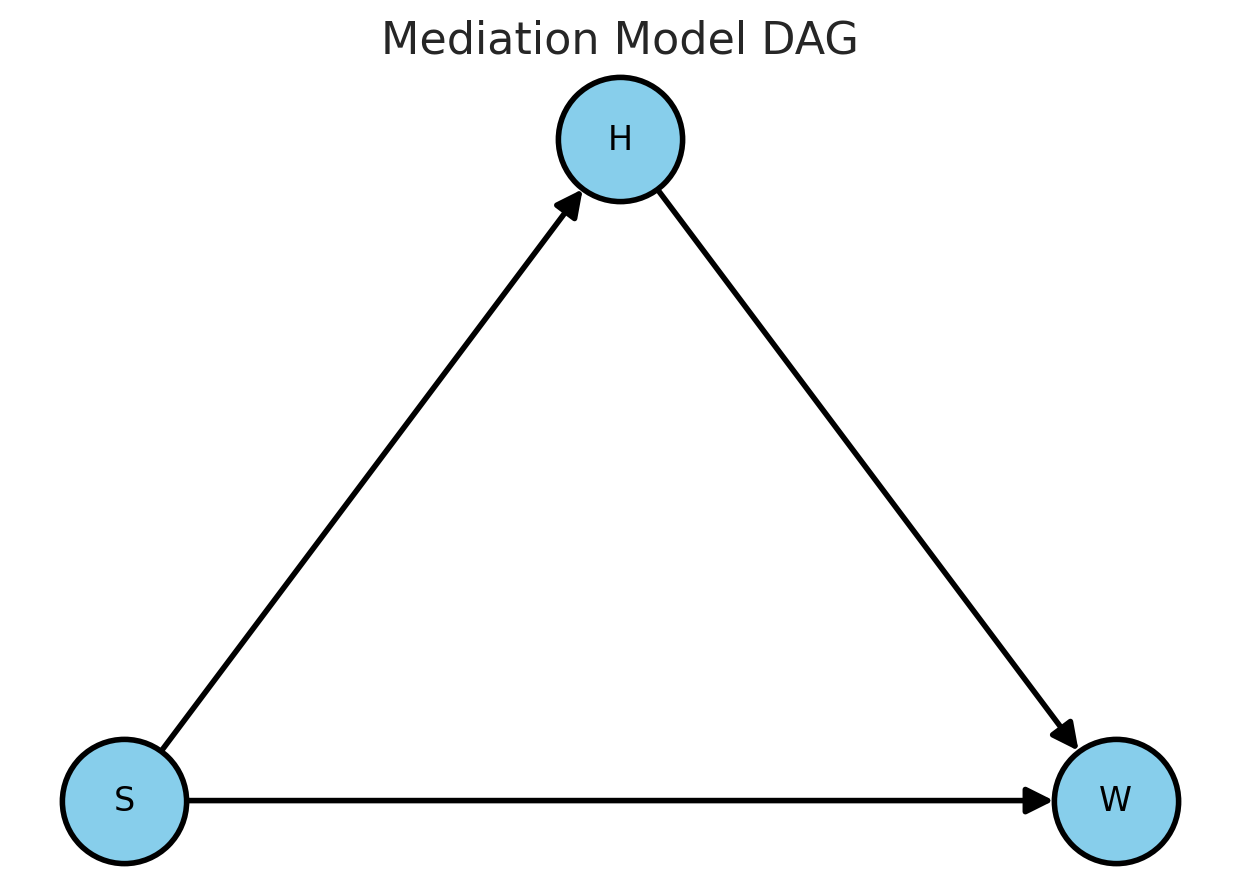

In [7]:
# Creazione del Directed Acyclic Graph (DAG) per il modello di mediazione
G = nx.DiGraph()

# Aggiunta dei nodi
G.add_nodes_from(["S", "W", "H"])

# Aggiunta degli archi che rappresentano le relazioni causali
G.add_edges_from([("S", "W"), ("S", "H"), ("H", "W")])

# Posizionamento dei nodi usando il layout 'planar'
pos = nx.planar_layout(G)

# Impostazioni per i nodi più grandi e le dimensioni globali più piccole
options = {
    "font_size": 12,
    "node_size": 2000,
    "node_color": "skyblue",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

plt.figure(figsize=(6, 4))  # Dimensioni globali più piccole
nx.draw(G, pos, **options, with_labels=True, arrowsize=20)

plt.title("Mediation Model DAG")
plt.show()

Rileggiamo il modello Stan. È da notare che i dati sono stati standardizzati per agevolare il campionamento e permettere un confronto diretto tra i diversi coefficienti.

In [8]:
stan_file = os.path.join('stan', 'mediation_model.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N; // Number of observations
  array[N] int S; // Sex indicator (0 for F, 1 for M), Predictor
  array[N] real H; // Height, Mediator
  array[N] real W; // Weight, Outcome
}

parameters {
  real alphaH; // Intercept for height model
  real betaH; // Effect of sex on height
  real alphaW; // Intercept for weight model
  real betaW_H; // Effect of height on weight
  real betaW_S; // Direct effect of sex on weight
  real<lower=0> sigmaH; // Std dev for height model
  real<lower=0> sigmaW; // Std dev for weight model
}

model {
  // Priors
  alphaH ~ normal(0, 1); // Less restrictive priors for intercepts and effects
  betaH ~ normal(0, 1);
  alphaW ~ normal(0, 1);
  betaW_H ~ normal(0, 1);
  betaW_S ~ normal(0, 1);
  sigmaH ~ cauchy(0, 1); // Using a Cauchy distribution for sigma, more appropriate for std devs
  sigmaW ~ cauchy(0, 1);
  
  // Mediation Model
  for (i in 1:N) {
    // A path: Effect of sex on height
    H[i] ~ normal(alphaH + betaH * S[i], sigmaH);
   

Creiamo un dizionario che include i dati nel formato atteso dal precedente codice Stan.

In [9]:
howell_data['H_standardized'] = (howell_data['height'] - howell_data['height'].mean()) / howell_data['height'].std()
howell_data['W_standardized'] = (howell_data['weight'] - howell_data['weight'].mean()) / howell_data['weight'].std()

stan_data = {
    "N": howell_data.shape[0],
    "S": howell_data["male"].to_numpy(),  # Ensuring this is an array if not already
    "H": howell_data["H_standardized"].to_numpy(),  # Use the standardized height
    "W": howell_data["W_standardized"].to_numpy()   # Use the standardized weight
}

Compiliamo il modello.

In [10]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=mediation_model
	 stan_file=/Users/corradocaudek/_repositories/ds4p/chapter_5/stan/mediation_model.stan
	 exe_file=/Users/corradocaudek/_repositories/ds4p/chapter_5/stan/mediation_model
	 compiler_options=stanc_options={}, cpp_options={}


Eseguiamo il campionamento.

In [11]:
fit = model.sample(data=stan_data, adapt_delta = 0.95)

06:51:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:51:54 - cmdstanpy - INFO - CmdStan done processing.
06:51:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'mediation_model.stan', line 31, column 4 to column 49)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'mediation_model.stan', line 31, column 4 to column 49)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'mediation_model.stan', line 31, column 4 to column 49)
Consider re-running with show_console=True if the above output is unclear!


In [12]:
print(fit.diagnose())

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp21v_i0bp/mediation_model5rm1gdaw/mediation_model-20240522065152_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp21v_i0bp/mediation_model5rm1gdaw/mediation_model-20240522065152_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp21v_i0bp/mediation_model5rm1gdaw/mediation_model-20240522065152_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp21v_i0bp/mediation_model5rm1gdaw/mediation_model-20240522065152_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Esaminiamo le tracce.

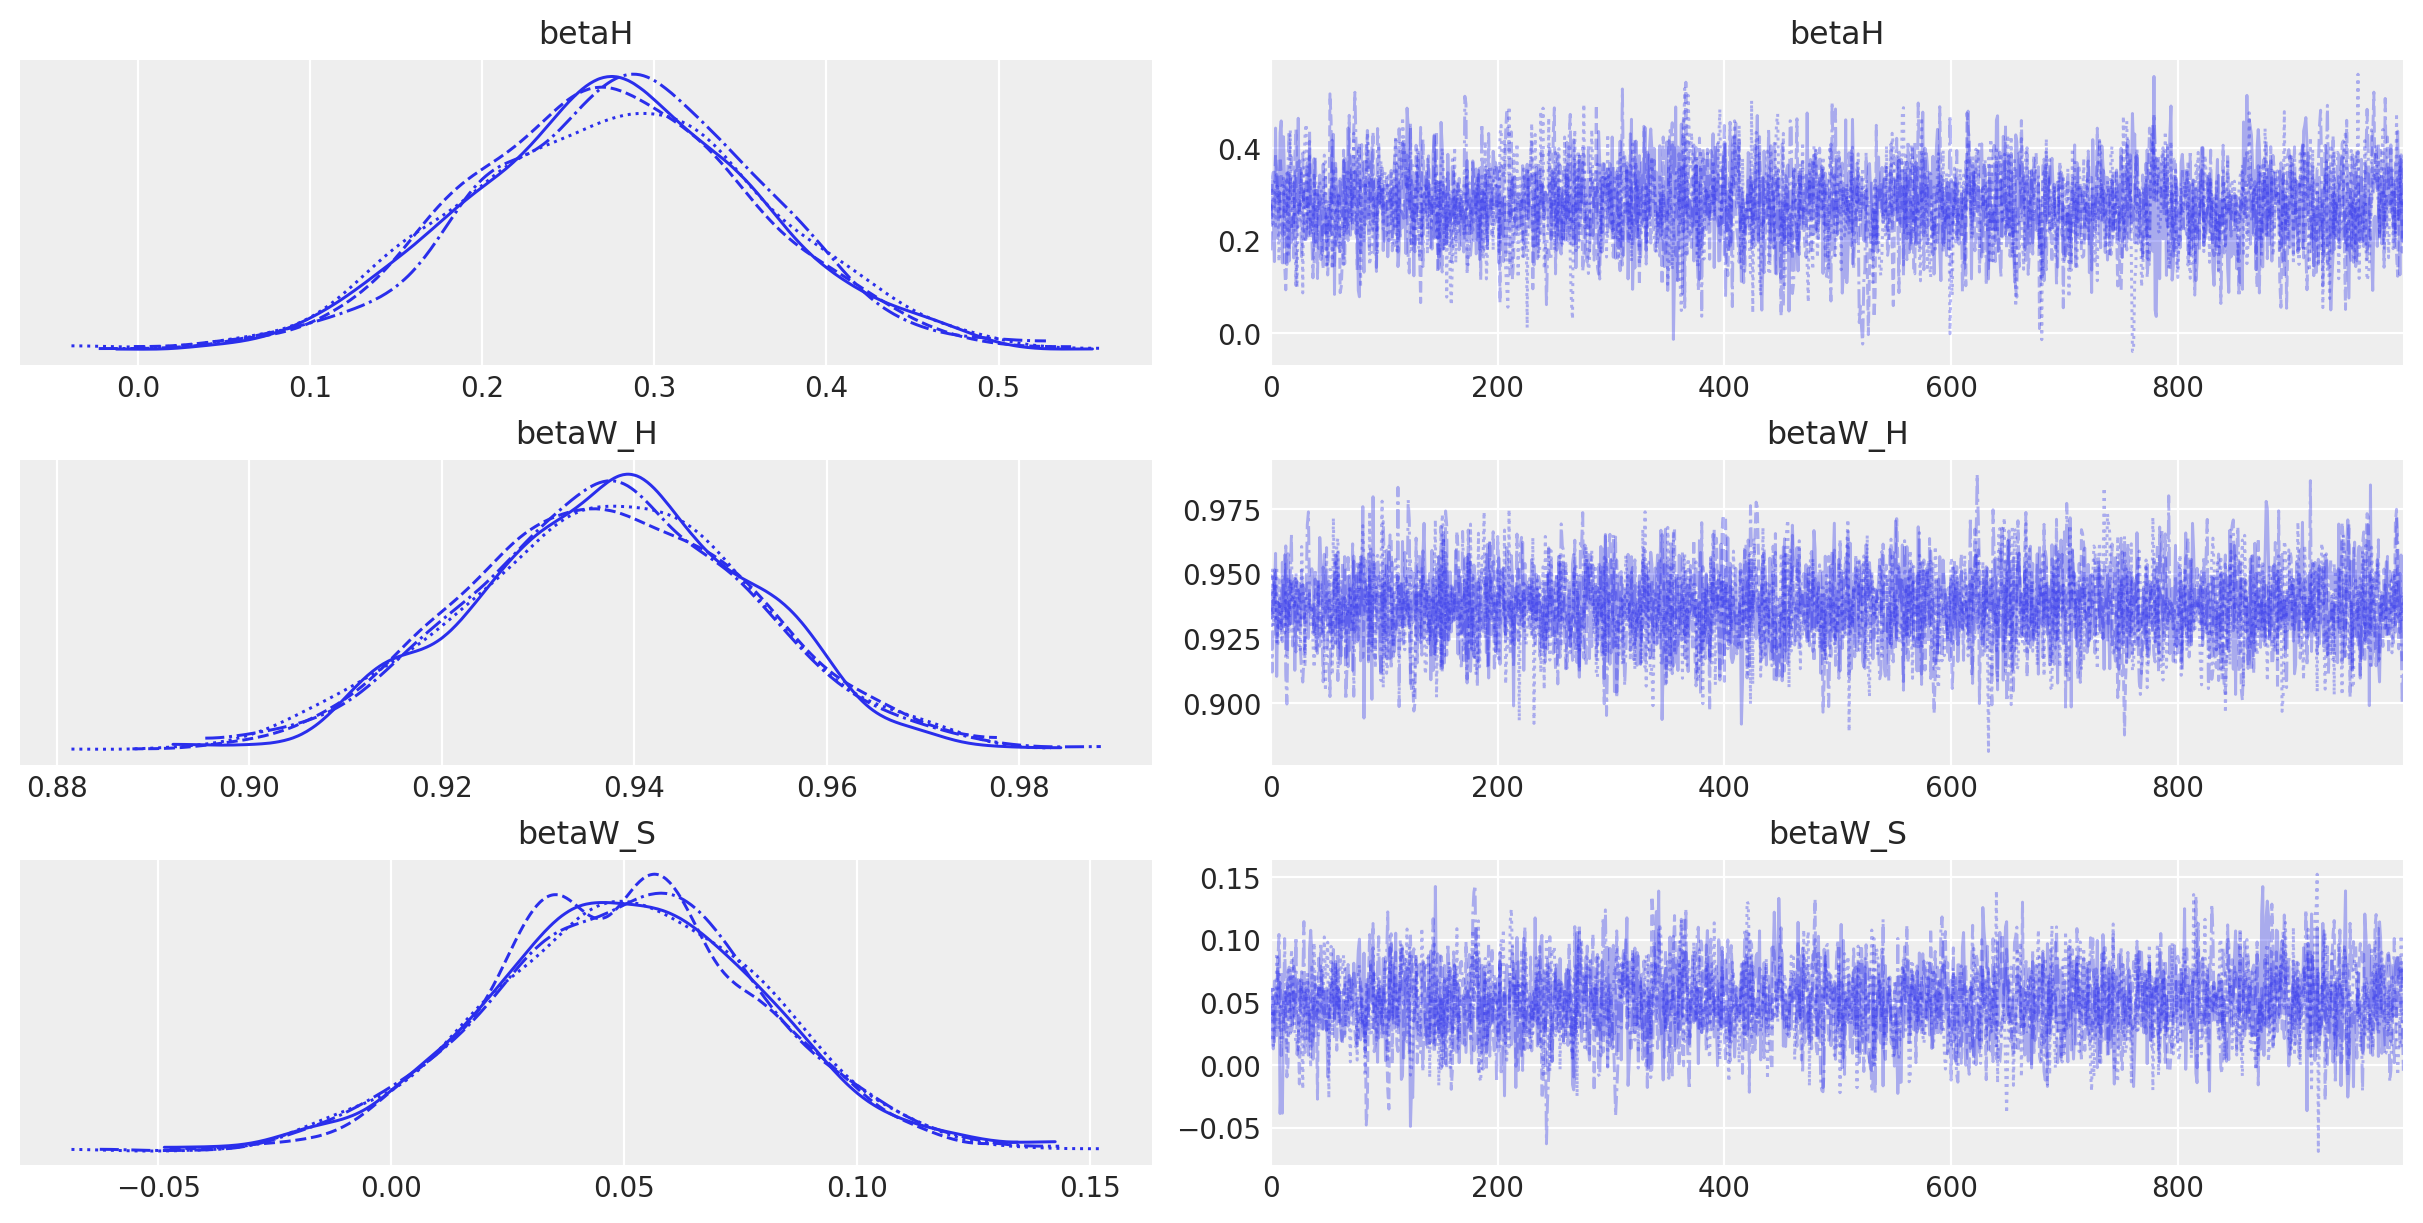

In [13]:
_ = az.plot_trace(fit, var_names=(["betaH", "betaW_H", "betaW_S"]))

Esaminiamo le medie a posteriori e gli intervalli di credibilità dei parametri.

In [14]:
az.summary(fit, var_names=(["betaH", "betaW_H", "betaW_S"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betaH,0.28,0.09,0.11,0.44,0.0,0.0,3139.90,2705.84,1.0
betaW_H,0.94,0.01,0.91,0.97,0.0,0.0,4113.00,2834.41,1.0
betaW_S,0.05,0.03,-0.01,0.11,0.0,0.0,2796.52,2773.80,1.0


Il genere ha scarso o addirittura nullo impatto diretto sul peso. Piuttosto, è principalmente l'altezza ad avere un effetto causale sul peso.

## Informazioni sull'Ambiente di Sviluppo

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Wed May 22 2024

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

cmdstanpy: 1.2.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.18.0
scipy     : 1.13.0
networkx  : 3.3
matplotlib: 3.8.4
pandas    : 2.2.2
seaborn   : 0.13.2
numpy     : 1.26.4

Watermark: 2.4.3

